# Homework 2 - Vertical FL and Generative Modeling

Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, the latter creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 

# Instructions

Submit your assignment in ILIAS as only the Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

### For any questions regarding this assignment, send an email to a.shankar@tudelft.nl

## Exercise 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_2b/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **3** random feature permutations and plot the training loss. Report whether/how shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 3 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ Describe what impact (if any) the permutations have on the loss and explain the observed pattern.

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))


class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum([local_models[i].local_out_dim for i in range(len(local_models))])
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)


class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

        # save history
        self.train_loss_history = []
        self.train_acc_history = []
        self.test_loss = None
        self.test_acc = None

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli
        self.cli_features = cli_features
        x = x.astype('float32')
        y = y.astype('float32')
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1

        # clear history for new training run
        self.train_loss_history = []
        self.train_acc_history = []

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]

                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            # store train accuracy and loss for each epoch
            avg_loss = total_loss.detach().numpy() / num_batches
            acc = correct / total
            self.train_loss_history.append(float(total_loss.item()/num_batches))
            self.train_acc_history.append(float((correct/total).item())) 

            if(epoch%10 == 0):
                print(f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}")

    def forward(self, x):
        local_outs = [self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype('float32')
        y = y.astype('float32')
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)

            # store test accuracy and loss
            self.test_acc = float(accuracy.item())
            self.test_loss = loss.item()
            return accuracy, loss

- _(1 point)_ Create 3 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.

In [3]:
def get_random_client_features(df, num_clients, categorical_cols, random_state=42):
    # get all base features (before one-hot encoding)
    all_features = df.drop("target", axis=1).columns.tolist()
    
    # group one-hot encoded features
    feature_groups = {}
    for feature in all_features:
        base_feature = feature.split('_')[0]
        if base_feature in categorical_cols:
            if base_feature not in feature_groups:
                feature_groups[base_feature] = []
            feature_groups[base_feature].append(feature)
        else:
            # add numerical as single groups
            feature_groups[feature] = [feature]
    
    # shuffle groups
    group_names = list(feature_groups.keys())
    np.random.seed(random_state)
    shuffled_groups = np.random.permutation(group_names)
    
    # split groups into clients
    split_points = np.linspace(0, len(shuffled_groups), num_clients+1, dtype=int)
    
    # add shuffled features parts to each client
    client_features = []
    for i in range(num_clients):
        groups = shuffled_groups[split_points[i]:split_points[i+1]]
        features = []
        for group in groups:
            features.extend(feature_groups[group])
        client_features.append(features)
    
    return client_features

In [4]:
def run(x, num_clients, df, categorical_cols, encoded_df_feature_names):
    print(f"\n------------------ Run {x+1} ------------------")
    client_feature_names = get_random_client_features(df, num_clients, categorical_cols, random_state=x)
    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    if '_' in name and column_name in name:
                        updated_names.append(name)
        client_feature_names[i] = updated_names

    # model architecture hyperparameters
    outs_per_client = 2
    bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
    final_out_dims = 2
    Network = VFLNetwork(bottom_models, final_out_dims)

    # training configurations
    EPOCHS = 300
    BATCH_SIZE = 64
    TRAIN_TEST_THRESH = 0.8
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
    Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients, client_feature_names, X_train, Y_train)

    accuracy, loss = Network.test(X_test, Y_test)
    return Network.train_loss_history, Network.train_acc_history, client_feature_names

In [19]:
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    df = pd.read_csv("../lab/tutorial_2a/heart.csv")
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  # convert categorical features to one-hot embeddings
    num_clients = 4 # asked for 4 clients
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    encoded_df_feature_names = list(X.columns)

    all_losses = []
    all_accuracy = []
    all_features = []
    num_permutations = 3
    for i in range(num_permutations):  # run 3 times with different splits
        losses, accuracy, client_features = run(i, num_clients, encoded_df, categorical_cols, encoded_df_feature_names)
        all_losses.append(losses)
        all_accuracy.append(accuracy)
        all_features.append(client_features)


------------------ Run 1 ------------------
Epoch: 0 Train accuracy: 51.77% Loss: 0.692
Epoch: 10 Train accuracy: 75.27% Loss: 0.513
Epoch: 20 Train accuracy: 76.74% Loss: 0.500
Epoch: 30 Train accuracy: 79.42% Loss: 0.469
Epoch: 40 Train accuracy: 77.47% Loss: 0.488
Epoch: 50 Train accuracy: 80.76% Loss: 0.438
Epoch: 60 Train accuracy: 80.02% Loss: 0.437
Epoch: 70 Train accuracy: 77.10% Loss: 0.511
Epoch: 80 Train accuracy: 82.10% Loss: 0.435
Epoch: 90 Train accuracy: 81.61% Loss: 0.440
Epoch: 100 Train accuracy: 81.85% Loss: 0.424
Epoch: 110 Train accuracy: 82.34% Loss: 0.404
Epoch: 120 Train accuracy: 82.46% Loss: 0.416
Epoch: 130 Train accuracy: 83.56% Loss: 0.380
Epoch: 140 Train accuracy: 84.17% Loss: 0.354
Epoch: 150 Train accuracy: 81.00% Loss: 0.417
Epoch: 160 Train accuracy: 86.72% Loss: 0.351
Epoch: 170 Train accuracy: 84.53% Loss: 0.364
Epoch: 180 Train accuracy: 84.53% Loss: 0.371
Epoch: 190 Train accuracy: 87.82% Loss: 0.331
Epoch: 200 Train accuracy: 86.60% Loss: 0.331


- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.

In [20]:
for i in range(num_permutations):
    print(f'Run {i+1}:\nFeatures: {all_features[i]}\n Accuracy: {all_accuracy[i][-1]}\n Loss: {all_losses[i][-1]}')

Run 1:
Features: [['cp_0', 'cp_1', 'cp_2', 'cp_3', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'oldpeak'], ['slope_0', 'slope_1', 'slope_2', 'chol', 'restecg_0', 'restecg_1', 'restecg_2'], ['trestbps', 'fbs_0', 'fbs_1', 'exang_0', 'exang_1'], ['thalach', 'age', 'sex_0', 'sex_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
 Accuracy: 0.8940316438674927
 Loss: 0.27297241871173566
Run 2:
Features: [['chol', 'thalach', 'oldpeak'], ['slope_0', 'slope_1', 'slope_2', 'trestbps', 'cp_0', 'cp_1', 'cp_2', 'cp_3'], ['age', 'fbs_0', 'fbs_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3'], ['exang_0', 'exang_1', 'restecg_0', 'restecg_1', 'restecg_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'sex_0', 'sex_1']]
 Accuracy: 0.9208282828330994
 Loss: 0.2097777403317965
Run 3:
Features: [['oldpeak', 'age', 'slope_0', 'slope_1', 'slope_2'], ['sex_0', 'sex_1', 'thalach', 'trestbps'], ['exang_0', 'exang_1', 'fbs_0', 'fbs_1', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4'], ['chol', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_

In [21]:
def plot_loss(all_losses, loss_title, labels, figsize=(8, 6)):

    fig, ax = plt.subplots(figsize=figsize)
    
    for i, losses in enumerate(all_losses):
        sns.lineplot(x=np.arange(len(losses)), y=losses,
                    label=labels[i], alpha=0.8, linewidth=1.5)
    
    plt.title(loss_title, fontsize=12, pad=10)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

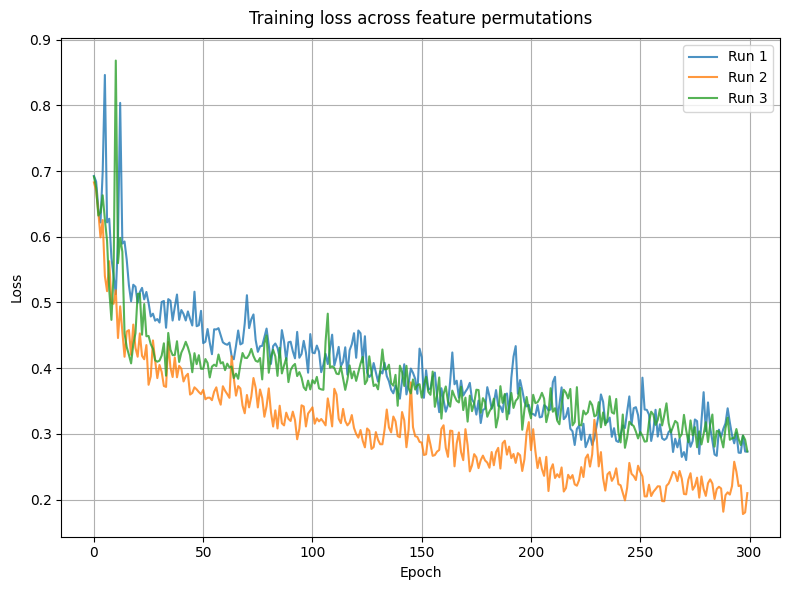

In [22]:
plot_loss(
    all_losses,
    loss_title='Training loss across feature permutations',
    labels=['Run 1', 'Run 2', 'Run 3']
)

- _(2 points)_ Describe what impact (if any) the permutations have on the loss and explain the observed pattern.

*The different permutations result in similar loss curvers. We see a steady decline after around 20 epochs for all permutations, but somehow the second run performs slightly better. In this run the following features are grouped together:*
- 'chol', 'thalach', 'oldpeak'
- 'slope_0', 'slope_1', 'slope_2', 'trestbps', 'cp_0', 'cp_1', 'cp_2', 'cp_3
- 'age', 'fbs_0', 'fbs_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3'
- 'exang_0', 'exang_1', 'restecg_0', 'restecg_1', 'restecg_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'sex_0', 'sex_1'

*The slight difference in performance could be caused by how clinically correlated features are assigned together to the same client. For example features like blood pressure ('threstbsp') and eeg slop ('slope_*') are assigned to the same model. The local client can then learn their relationship better, which results in a better feature space and more invariant fetaures and increases the overall performance.*


## Exercise 2: Scaling clients in VFL (5 points)

With the same template as above, experiment with how increasing the number of clients affects model performance. Explain the policy chosen for distributing features for different numbers of clients.

Scoring:
- _(1 point)_ Explain your scheme for partitioning the feature space under increasing number of clients.
- _(1 point)_ Implement the above explained partition mechanism for the requested client counts for the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.


- _(1 point)_ Explain your scheme for partitioning the feature space under increasing number of clients.

*We first group one-hot encoded features together. For example after one-hot encoding sex, we get two columns (sex_0 and sex_1) which represent male and female. If we would assigne them to differnet clients, we might miss features, which correalte with different sexes. We treat numerical features as standalone groups. In a next step, we randomly permute these groups, creating different feature combinations and split them up evenly betwen the number of clients.*

- _(1 point)_ Implement the above explained partition mechanism for the requested client counts for the discriminative VFL model.

In [23]:
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    df = pd.read_csv("../lab/tutorial_2a/heart.csv")
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  # convert categorical features to one-hot embeddings
    num_clients = [2,4,6,8,10]
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    encoded_df_feature_names = list(X.columns)

    all_losses = []
    all_accuracy = []
    all_features = []
    for i in range(len(num_clients)):  # run 3 times with different splits
        losses, accuracy, client_features = run(i, num_clients[i], encoded_df, categorical_cols, encoded_df_feature_names)
        all_losses.append(losses)
        all_accuracy.append(accuracy)
        all_features.append(client_features)


------------------ Run 1 ------------------
Epoch: 0 Train accuracy: 55.79% Loss: 0.690
Epoch: 10 Train accuracy: 80.02% Loss: 0.490
Epoch: 20 Train accuracy: 81.12% Loss: 0.448
Epoch: 30 Train accuracy: 80.15% Loss: 0.461
Epoch: 40 Train accuracy: 82.70% Loss: 0.404
Epoch: 50 Train accuracy: 84.29% Loss: 0.386
Epoch: 60 Train accuracy: 81.24% Loss: 0.418
Epoch: 70 Train accuracy: 84.77% Loss: 0.390
Epoch: 80 Train accuracy: 84.41% Loss: 0.389
Epoch: 90 Train accuracy: 83.56% Loss: 0.388
Epoch: 100 Train accuracy: 86.11% Loss: 0.361
Epoch: 110 Train accuracy: 86.97% Loss: 0.348
Epoch: 120 Train accuracy: 88.43% Loss: 0.325
Epoch: 130 Train accuracy: 88.06% Loss: 0.296
Epoch: 140 Train accuracy: 88.31% Loss: 0.314
Epoch: 150 Train accuracy: 87.58% Loss: 0.321
Epoch: 160 Train accuracy: 89.04% Loss: 0.291
Epoch: 170 Train accuracy: 90.13% Loss: 0.263
Epoch: 180 Train accuracy: 90.13% Loss: 0.281
Epoch: 190 Train accuracy: 90.01% Loss: 0.263
Epoch: 200 Train accuracy: 91.23% Loss: 0.231


- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.

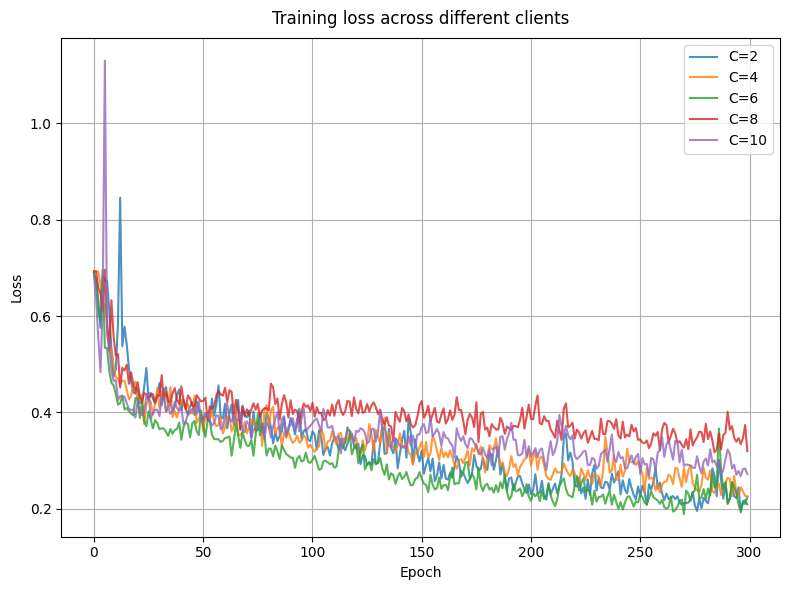

In [24]:
plot_loss(
    all_losses, 
    loss_title='Training loss across different clients',
    labels=['C=2','C=4', 'C=6', 'C=8', 'C=10']
)

- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

We se that the loss that the higher the number of clients, the higher the loss. This decrease in performance could be, because we split up strongly correlated features between clients. Because of the vertical nature of the model, each client has only access to its assigned features and the other clients will never see them and therefore will not be able to learn from them. So the more we split, the less probable it is to have strongly correlated features grouped together, the less each local client will be able to learn from significant fetaure and the worse the overall performance will get.*

## Exercise 3: Bridging VFL and generative modeling (10 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. Combine VFL with variational autoencoders (VAEs) using the architecture described as follows. Each client uses a local encoder, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another local MLP (decoder) at each client. Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features.
- _(2 points)_ Define the encoder and decoder MLPs held by each.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.
- _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?
- _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

- _(1 point)_ Preprocess the dataset and partition the features.

In [13]:
def partition_data(df, num_clients):
    num_features = df.shape[1] # overall featrue number
    # handle uneven feature numbers
    min_features = num_features // num_clients # min/client
    max_features = num_features % num_clients # max/client
    
    partitions = []
    start_idx = 0
    for i in range(num_clients):
        # in case of uneven features numbers, add one less to last client
        end_idx = start_idx + min_features + (1 if i < max_features else 0)
        # extract data for defined partition
        partition = df.iloc[:, start_idx:end_idx]
        print(f"Partition {i+1}:\n", partition.columns.tolist())
        # transform dataframe into tensor (tensor<-numpy<-df)
        partitions.append(torch.FloatTensor(partition.astype('float32').to_numpy()))
        start_idx = end_idx
    return partitions

- _(2 points)_ Define the encoder and decoder MLPs held by each.

In [14]:
class ClientMLPEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, latent_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class ClientMLPDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.

In [15]:
class VAE(nn.Module):
    def __init__(self, clients_latent_dim, H=50, H2=12, latent_dim=3):
        super(VAE, self).__init__()
        
        # Encoder
        self.linear1 = nn.Linear(clients_latent_dim, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)  # mu
        self.fc22 = nn.Linear(latent_dim, latent_dim)  # logvar

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, clients_latent_dim)
        self.lin_bn6 = nn.BatchNorm1d(num_features=clients_latent_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        
        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        
        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.

In [16]:
class VFL(nn.Module):
    def __init__(self, client_encoders, client_decoders, vae):
        super().__init__()
        self.client_encoders = nn.ModuleList(client_encoders)
        self.client_decoders = nn.ModuleList(client_decoders)
        self.vae = vae
    
    def forward(self, client_partitions):
        #  local clients encodes input into latent space
        encoded_data = []
        for encoder, input in zip(self.client_encoders, client_partitions):
            encoded_data.append(encoder(input))
        client_latents = torch.cat(encoded_data, dim=1)
        
        # vae gets encoded input and generate synthetic latent space of it
        vae_output_latents, mu, logvar = self.vae(client_latents)
        
        # partition synthetic latents
        partition_sizes = [latent.shape[1] for latent in encoded_data]
        vae_output_latents_partitioned = torch.split(vae_output_latents, partition_sizes, dim=1)
        
        # local client decodes synthetic latent space into original input space 
        decoded_data = []
        for decoder, output in zip(self.client_decoders, vae_output_latents_partitioned):
            decoded_data.append(decoder(output))

        return decoded_data, mu, logvar

In [17]:
class VFL_VAE(nn.Module):
    def __init__(self, client_encoders, client_decoders, server_vae):
        super().__init__()
        self.client_encoders = nn.ModuleList(client_encoders)
        self.client_decoders = nn.ModuleList(client_decoders)
        self.server_vae = server_vae
    
    def forward(self, x_partitions):
        # Clients encode data
        client_latents = [encoder(x) for encoder, x in zip(self.client_encoders, x_partitions)]
        z_server = torch.cat(client_latents, dim=1)
        
        # Server processes
        recon_z, mu, logvar = self.server_vae(z_server)
        
        # Split latents back to clients
        split_sizes = [latent.shape[1] for latent in client_latents]
        recon_z_split = torch.split(recon_z, split_sizes, dim=1)
        
        # Clients decode
        recon_x = [decoder(z) for decoder, z in zip(self.client_decoders, recon_z_split)]
        return recon_x, mu, logvar


- _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.

In [18]:
if __name__ == "__main__":
    # set seed
    torch.manual_seed(42)
    np.random.seed(42)

    # load dataset
    df = pd.read_csv("../lab/tutorial_2a/heart.csv")

    # preprocess data
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])
    encoded_df = pd.get_dummies(df, columns=categorical_cols)
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    
    # split train and by threshhold
    TRAIN_TEST_THRESH = 0.8
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]    

    # partition data
    NUM_CLIENTS = 3
    partitions = partition_data(X_train, num_clients=NUM_CLIENTS)
    
    # define dimensions
    CLIENT_LATENT_DIM = 4
    SERVER_LATENT_DIM = 3
    
    # initialize models
    client_encoders = []
    client_decoders = []
    for i in range(NUM_CLIENTS):
        client_encoders.append(ClientMLPEncoder(partitions[i].shape[1], CLIENT_LATENT_DIM))
        client_decoders.append(ClientMLPDecoder(CLIENT_LATENT_DIM, partitions[i].shape[1]))
    
    # input of server side vae is total of dim of client latent spaces
    vae = VAE(NUM_CLIENTS * CLIENT_LATENT_DIM)
    vfl = VFL(client_encoders, client_decoders, vae)

    # train
    EPOCHS = 300
    LR = 1e-3
    optimizer = optim.Adam(vfl.parameters(), lr=LR)
    print(f'---------Training for {EPOCHS} Epochs--------\n')
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # forward pass
        reconstruction, mu, logvar = vfl(partitions)
        
        # evaluate reconstruction using MSE (reconstruction loss)
        # and KLD (divergence in learned latent distribution)
        loss_mse = 0
        for output, input in zip(reconstruction, partitions):
            loss_mse += F.mse_loss(output, input)
        loss_kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_mse + loss_kld # overall loss
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}: Overall loss: {loss}, MSE: {loss_mse.item():.4f}, KLD: {loss_kld.item():.4f}")

Partition 1:
 ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2']
Partition 2:
 ['cp_3', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1']
Partition 3:
 ['slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3']
---------Training for 300 Epochs--------

Epoch 1: Overall loss: 392.22674560546875, MSE: 1.0892, KLD: 391.1376
Epoch 2: Overall loss: 357.7454528808594, MSE: 1.0607, KLD: 356.6848
Epoch 3: Overall loss: 335.2701416015625, MSE: 1.0329, KLD: 334.2372
Epoch 4: Overall loss: 318.5019836425781, MSE: 1.0010, KLD: 317.5010
Epoch 5: Overall loss: 301.8916015625, MSE: 0.9803, KLD: 300.9113
Epoch 6: Overall loss: 285.7341613769531, MSE: 0.9608, KLD: 284.7734
Epoch 7: Overall loss: 270.331298828125, MSE: 0.9397, KLD: 269.3916
Epoch 8: Overall loss: 257.0279541015625, MSE: 0.9186, KLD: 256.1093
Epoch 9: Overall loss: 246.43467712402344, MSE: 0.9022, KLD: 245.5325
Epo

- _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?

*If we train the MLPS and VAE seperatly, the latent spaces learned by the clients are not updated after we send them to the VAE. So the clients can't learn from the VAE. Meaing, that the clients can't improve encoding thr raw data into latent space and decoding from synthetic latent space back again based on the loss. Also the VAE is limited in it's learning by the clients latent space, so if this is not good, the VAE will also perform suboptimal.*

- _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.

| Focus            | Alternative                                                                 | Implementation                                                                 |
|------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Performance**  | Worse, because clients can't improve their learned latent space    | Better, we can use loss from the VAE to improve clients encoding/decoding |
| **Privacy**      | Better, because we only share final layer                                   | Worse, we share all gradients                                                 |
| **Communication Cost** | Lower, only once after training local clients                            | Higher, we constantly share gradients                                            |